In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/combined_datasets.csv").fillna("")

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [4]:
# Create a book_scroll column
df['book_scroll'] = df['book'] + "_" + df['scroll']

In [5]:
len(df)

13637

In [6]:
set(df.cmpl_constr)

{'', 'dir-he', 'prep', 'prep + dir-he', 'vc'}

In [7]:
exclude_comments = ["min excluded", "reconstructed", "verb rec"]

df_goals = df[~df['comments'].isin(exclude_comments)].copy()
df_goals = df[df['spatial_arg_type'] == "goal"].copy()

In [8]:
len(df_goals)

4665

## Part 1: select an example dataframe

In [9]:
# Overall counts
lex_counts = df_goals['lex'].value_counts().reset_index()
lex_counts.columns = ['lex', 'count']

# Show top 10
print(lex_counts.head(10))

    lex  count
0  BW>[   1891
1  CWB[    471
2  <LH[    445
3  HLK[    387
4  JY>[    268
5  JRD[    225
6  QRB[    186
7  NPL[    143
8  <BR[    130
9  NGC[     79


In [10]:
# Save the 5 most frequent verbs in a list
freq_verbs = lex_counts.head(5)['lex'].to_list()

In [11]:
# Filter a dataframe with only the 5 most frequent verbs
df_top5 = df_goals[df_goals['lex'].isin(freq_verbs)]

In [12]:
# Select books for example

# Count total occurrences of all top5 verbs per book_scroll
book_totals = (
    df_top5.groupby('book_scroll')
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)

# Take the top 20
top20_books = book_totals.head(20)

print(top20_books)

         book_scroll  count
100       Genesis_MT    261
117      Jeremiah_MT    251
8        1_Samuel_MT    209
9    2_Chronicles_MT    198
11        2_Kings_MT    178
15       2_Samuel_MT    167
92        Ezekiel_MT    158
5         1_Kings_MT    144
132        Judges_MT    139
85         Exodus_MT    135
56    Deuteronomy_MT    131
130        Joshua_MT    124
155       Numbers_MT    124
112    Isaiah_1Qisaa     97
113        Isaiah_MT     96
143     Leviticus_MT     81
170        Psalms_MT     77
3    1_Chronicles_MT     59
119           Job_MT     40
152      Nehemiah_MT     34


In [13]:
# Select one Qumran sectarian scroll for example
qumran_scrolls = ["1QH_1QH", "1QM_1QM", "1QS_1QS"]

qumran_counts = (
    df_top5[df_top5['book_scroll'].isin(qumran_scrolls)]
    .groupby('book_scroll')
    .size()
    .reset_index(name='count')
)

print(qumran_counts)

  book_scroll  count
0     1QH_1QH     16
1     1QM_1QM     24
2     1QS_1QS     19


In [14]:
selected_books = ["Genesis_MT", "1_Samuel_MT", "Psalms_MT", "Jeremiah_MT", "1QM_1QM"]
pentateuch_books = ["Genesis_MT", "Exodus_MT", "Deuteronomy_MT", "Leviticus_MT", "Numbers_MT"]

In [15]:
# Create a dataframe for analysis
df_selected = df_top5[df_top5['book_scroll'].isin(selected_books)]
df_pentateuch = df_top5[df_top5['book_scroll'].isin(pentateuch_books)]

## Part 2: Visualize goal markings in the different books - Selected Books

In [ ]:
selected_books = ["Genesis_MT", "1_Samuel_MT", "Psalms_MT", "Jeremiah_MT", "1QM_1QM"]

In [ ]:
df_selected.query("book_scroll == '1QM_1QM'")[['lex','cmpl_constr']].value_counts()

In [ ]:
# 1) Compute counts and percentages within each (lex × book_scroll)
counts = (
    df_selected
    .groupby(['lex', 'book_scroll', 'cmpl_constr'])
    .size()
    .reset_index(name='count')
)

counts['percent'] = counts.groupby(['lex', 'book_scroll'])['count'].transform(
    lambda x: x / x.sum() * 100
)

# 2) Stable orders (works with any df_selected)
# Books (order by total tokens across verbs; tweak if you want alphabetical etc.)
book_order = (
    df_selected.groupby('book_scroll')
    .size()
    .sort_values(ascending=False)
    .index
    .tolist()
)

# Complement constructions (sorted for stability)
cmpl_types = sorted(df_selected['cmpl_constr'].dropna().unique().tolist())

# 3) One global, consistent color per cmpl_constr across all plots
palette = dict(zip(cmpl_types, sns.color_palette("tab10", n_colors=len(cmpl_types))))

# 4) Plot one figure per verb
verbs = sorted(df_selected['lex'].dropna().unique().tolist())

for verb in verbs:
    sub = counts[counts['lex'] == verb].copy()
    # enforce consistent x order across all verb plots
    sub['book_scroll'] = pd.Categorical(sub['book_scroll'], categories=book_order, ordered=True)

    plt.figure(figsize=(8, 4.8))
    ax = sns.barplot(
        data=sub,
        x="book_scroll", y="percent",
        hue="cmpl_constr",
        order=book_order,
        palette=palette,
        dodge=True
    )
    ax.set_title(f"Complement constructions for {verb} (%)")
    ax.set_xlabel("Book/Scroll")
    ax.set_ylabel("Percent")
    ax.tick_params(axis='x', rotation=45)

    # place a single, consistent legend outside the plot area
    ax.legend(title="cmpl_constr", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()
    plt.show()

In [ ]:
# --- 1) Stable orders (generic)
book_order = (
    df_selected.groupby("book_scroll")
    .size().sort_values(ascending=False).index.tolist()
)
verb_order = sorted(df_selected["lex"].dropna().unique().tolist())
cmpl_types = sorted(df_selected["cmpl_constr"].dropna().unique().tolist())

# --- 2) Build full (book × verb × cmpl) grid and counts
grid = (
    pd.MultiIndex.from_product(
        [book_order, verb_order, cmpl_types],
        names=["book_scroll", "lex", "cmpl_constr"]
    ).to_frame(index=False)
)

counts_raw = (
    df_selected
    .dropna(subset=["cmpl_constr"])
    .groupby(["book_scroll", "lex", "cmpl_constr"])
    .size().reset_index(name="count")
)

counts = grid.merge(counts_raw, on=["book_scroll","lex","cmpl_constr"], how="left")
counts["count"] = counts["count"].fillna(0).astype(int)

# --- 3) Percent within each (book × verb)
totals = counts.groupby(["book_scroll","lex"])["count"].transform("sum")
counts["percent"] = np.where(totals > 0, counts["count"] / totals * 100, 0.0)

# --- 4) Consistent colors across all books
palette = dict(zip(cmpl_types, sns.color_palette("tab10", n_colors=len(cmpl_types))))

# --- 5) Plot one figure per book
for book in book_order:
    sub = counts[counts["book_scroll"] == book].copy()
    # enforce consistent verb order on x-axis
    sub["lex"] = pd.Categorical(sub["lex"], categories=verb_order, ordered=True)

    plt.figure(figsize=(9, 5))
    ax = sns.barplot(
        data=sub,
        x="lex", y="percent",
        hue="cmpl_constr",
        order=verb_order,
        hue_order=cmpl_types,
        palette=palette,
        dodge=True
    )
    ax.set_title(f"Complement constructions in {book} (%)")
    ax.set_xlabel("Verb (lex)")
    ax.set_ylabel("Percent")
    ax.tick_params(axis="x", rotation=45)

    # Optional: mark verbs with no data in this book
    zero_verbs = sub.groupby("lex")["count"].sum().reindex(verb_order, fill_value=0)
    for xtick, (vb, tot) in zip(ax.get_xticks(), zero_verbs.items()):
        if tot == 0:
            ax.text(xtick, 2, "no data", ha="center", va="bottom", fontsize=8, rotation=90)

    # One legend outside the axes
    ax.legend(title="cmpl_constr", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()
    plt.show()

# Part 3: Matrix approach

## 1. Five selected books, with five books from different sections, including 1QM - raw 

## Heatmap

## Table

## 2. Five selected books, correct for global imbalance

## Heatmap

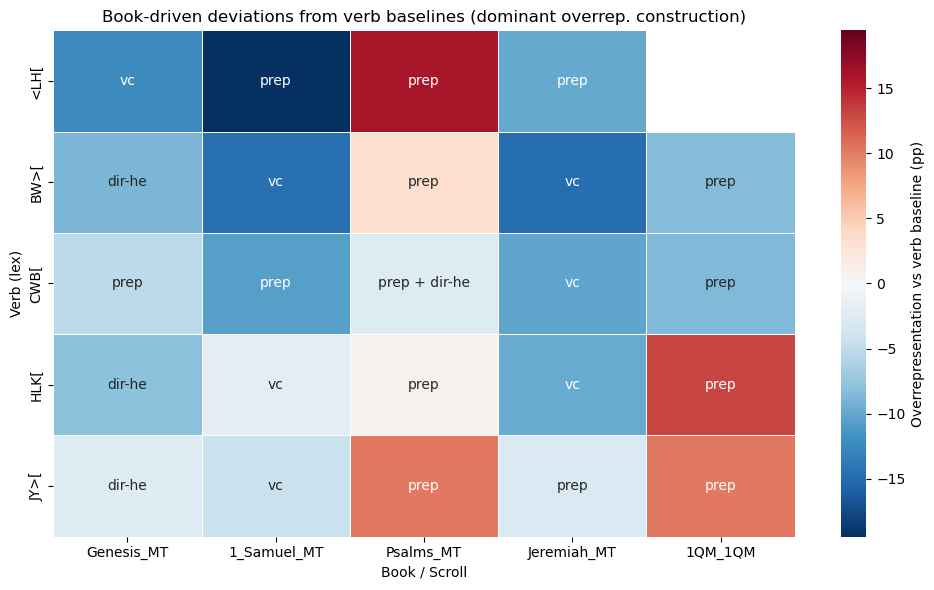

In [50]:
# -------- Inputs --------
selected_books = ["Genesis_MT", "1_Samuel_MT", "Psalms_MT", "Jeremiah_MT", "1QM_1QM"]

# 1) Get counts and within-(lex × book) percentages from FULL df_top5
counts = (
    df_top5
    .dropna(subset=["cmpl_constr"])
    .groupby(["lex", "book_scroll", "cmpl_constr"])
    .size()
    .reset_index(name="count")
)
counts["percent"] = (
    counts.groupby(["lex","book_scroll"])["count"]
          .transform(lambda x: x / x.sum() * 100)
)

# Stable orders (based on full df_top5)
book_order = (
    df_top5.groupby("book_scroll").size()
    .sort_values(ascending=False).index.tolist()
)
verbs = sorted(df_top5["lex"].dropna().unique().tolist())
cmpl_types = sorted(df_top5["cmpl_constr"].dropna().unique().tolist())

# 2) Compute verb-level baselines (mean % per verb × construction) over ALL df_top5
baseline = (
    counts.groupby(["lex","cmpl_constr"])["percent"]
          .mean().reset_index(name="baseline_percent")
)

# 3) Merge baseline into counts and compute deviations
counts_dev = counts.merge(baseline, on=["lex","cmpl_constr"], how="left")
counts_dev["deviation"] = counts_dev["percent"] - counts_dev["baseline_percent"]

# 4) For each (verb × book), pick the construction with max positive deviation
idx = counts_dev.groupby(["lex","book_scroll"])["deviation"].idxmax()
dominant_dev = counts_dev.loc[idx].copy()

# 5) Build matrices (labels = construction; values = deviation)
matrix_labels   = dominant_dev.pivot(index="lex", columns="book_scroll", values="cmpl_constr")
matrix_strength = dominant_dev.pivot(index="lex", columns="book_scroll", values="deviation")

# Reindex to stable order (verbs same, columns restricted to selected_books only)
matrix_labels   = matrix_labels.reindex(index=verbs, columns=selected_books)
matrix_strength = matrix_strength.reindex(index=verbs, columns=selected_books)

# 6) Plot heatmap for SELECTED books only
plt.figure(figsize=(10, 6))
vals = np.abs(matrix_strength.to_numpy().ravel())
vals = vals[~np.isnan(vals)]
vmax_abs = max(8, float(vals.max())) if vals.size > 0 else 8

ax = sns.heatmap(
    matrix_strength,
    cmap="RdBu_r", vmin=-vmax_abs, vmax=vmax_abs,
    center=0,
    annot=matrix_labels, fmt="",
    cbar_kws={"label": "Overrepresentation vs verb baseline (pp)"},
    linewidths=0.5, linecolor="white"
)
ax.set_title("Book-driven deviations from verb baselines (dominant overrep. construction)")
ax.set_xlabel("Book / Scroll")
ax.set_ylabel("Verb (lex)")
plt.tight_layout()
plt.show()

## Table

In [44]:
# -------- Inputs --------
selected_books = ["Genesis_MT", "1_Samuel_MT", "Psalms_MT", "Jeremiah_MT", "1QM_1QM"]

# 1) Raw counts per verb × book × construction, from FULL df_top5
counts_all = (
    df_top5.dropna(subset=["cmpl_constr"])
    .groupby(["lex","book_scroll","cmpl_constr"])
    .size().reset_index(name="count")
)

# 2) Percent within each (verb × book), from FULL df_top5
counts_all["percent"] = counts_all.groupby(["lex","book_scroll"])["count"] \
                                  .transform(lambda x: x / x.sum() * 100)

# 3) Baseline per (verb × construction): average across ALL books in df_top5
baseline = counts_all.groupby(["lex","cmpl_constr"])["percent"] \
                     .mean().reset_index(name="baseline_percent")

# 4) Keep only selected_books for display
counts_sel = counts_all[counts_all["book_scroll"].isin(selected_books)].copy()

# 5) Merge baseline into selected counts and compute deviation (pp)
counts_dev = counts_sel.merge(baseline, on=["lex","cmpl_constr"], how="left")
counts_dev["deviation_pp"] = counts_dev["percent"] - counts_dev["baseline_percent"]

# 6) Pivot to see deviations (handles global imbalance)
dev_pivot = counts_dev.pivot_table(
    index=["lex","cmpl_constr"],
    columns="book_scroll",
    values="deviation_pp",
    fill_value=0
)

dev_pivot

book_scroll           1QM_1QM  1_Samuel_MT  Genesis_MT  Jeremiah_MT  Psalms_MT
lex  cmpl_constr                                                              
<LH[ dir-he          0.000000   -31.490120  -14.500873   -37.463836   0.000000
     prep            0.000000   -19.437575  -43.953704    -9.879630  16.046296
     vc              0.000000   -19.851634  -12.324752   -23.435863   0.000000
BW>[ dir-he          0.000000   -24.101077   -8.921784   -28.302303   0.000000
     prep           -8.358199   -21.729197  -20.829855   -17.341651   3.337707
     vc            -15.301848   -14.642714  -30.721349   -14.829034 -26.997754
CWB[ dir-he          0.000000   -16.192546  -11.331435   -19.942546   0.000000
     prep           -8.642337   -10.725670   -5.309003   -16.975670 -13.028301
     prep + dir-he   0.000000     0.000000    0.000000     0.000000  -2.631579
     vc            -16.025324   -20.191991  -30.469769   -10.191991 -16.902517
HLK[ dir-he          0.000000   -17.731296   -8.044885   -17.017011   0.000000
     prep           13.173732   -29.683411  -20.972610   -22.540554   0.673732
     vc              0.000000    -1.992607  -20.389820    -9.849750 -15.206893
JY>[ dir-he          0.000000   -29.762274   -2.411846     0.000000   0.000000
     prep           10.320085   -34.124359  -35.833761    -3.013248  10.320085
     vc              0.000000    -4.252168  -29.893194   -24.252168   0.000000

## Pentateuch - with global imbalance corrected

## Heatmap

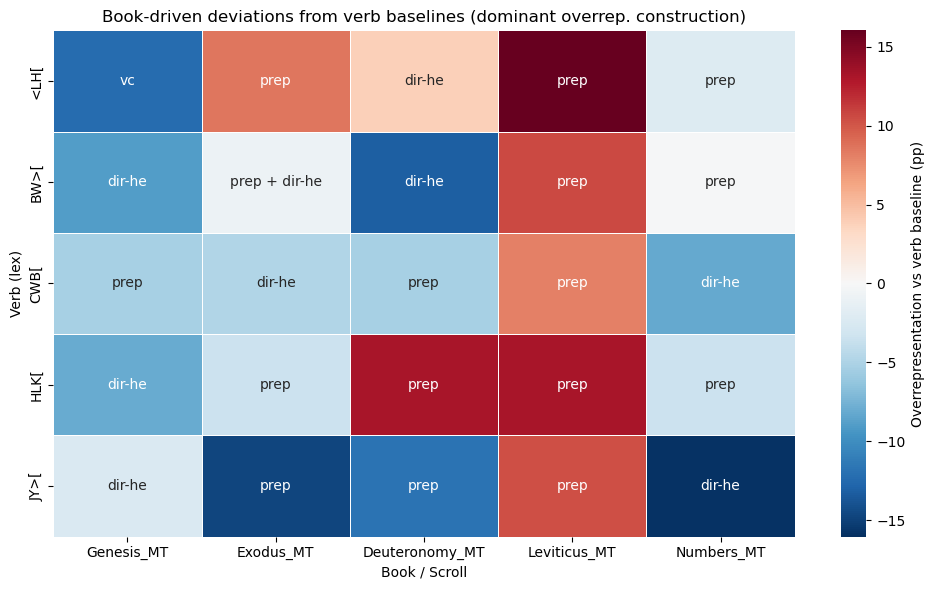

In [51]:
# -------- Inputs --------
selected_books = ["Genesis_MT", "Exodus_MT", "Deuteronomy_MT", "Leviticus_MT", "Numbers_MT"]

# 1) Get counts and within-(lex × book) percentages from FULL df_top5
counts = (
    df_top5
    .dropna(subset=["cmpl_constr"])
    .groupby(["lex", "book_scroll", "cmpl_constr"])
    .size()
    .reset_index(name="count")
)
counts["percent"] = (
    counts.groupby(["lex","book_scroll"])["count"]
          .transform(lambda x: x / x.sum() * 100)
)

# Stable orders (based on full df_top5)
book_order = (
    df_top5.groupby("book_scroll").size()
    .sort_values(ascending=False).index.tolist()
)
verbs = sorted(df_top5["lex"].dropna().unique().tolist())
cmpl_types = sorted(df_top5["cmpl_constr"].dropna().unique().tolist())

# 2) Compute verb-level baselines (mean % per verb × construction) over ALL df_top5
baseline = (
    counts.groupby(["lex","cmpl_constr"])["percent"]
          .mean().reset_index(name="baseline_percent")
)

# 3) Merge baseline into counts and compute deviations
counts_dev = counts.merge(baseline, on=["lex","cmpl_constr"], how="left")
counts_dev["deviation"] = counts_dev["percent"] - counts_dev["baseline_percent"]

# 4) For each (verb × book), pick the construction with max positive deviation
idx = counts_dev.groupby(["lex","book_scroll"])["deviation"].idxmax()
dominant_dev = counts_dev.loc[idx].copy()

# 5) Build matrices (labels = construction; values = deviation)
matrix_labels   = dominant_dev.pivot(index="lex", columns="book_scroll", values="cmpl_constr")
matrix_strength = dominant_dev.pivot(index="lex", columns="book_scroll", values="deviation")

# Reindex to stable order (verbs same, columns restricted to selected_books only)
matrix_labels   = matrix_labels.reindex(index=verbs, columns=selected_books)
matrix_strength = matrix_strength.reindex(index=verbs, columns=selected_books)

# 6) Plot heatmap for SELECTED books only
plt.figure(figsize=(10, 6))
vals = np.abs(matrix_strength.to_numpy().ravel())
vals = vals[~np.isnan(vals)]
vmax_abs = max(8, float(vals.max())) if vals.size > 0 else 8

ax = sns.heatmap(
    matrix_strength,
    cmap="RdBu_r", vmin=-vmax_abs, vmax=vmax_abs,
    center=0,
    annot=matrix_labels, fmt="",
    cbar_kws={"label": "Overrepresentation vs verb baseline (pp)"},
    linewidths=0.5, linecolor="white"
)
ax.set_title("Book-driven deviations from verb baselines (dominant overrep. construction)")
ax.set_xlabel("Book / Scroll")
ax.set_ylabel("Verb (lex)")
plt.tight_layout()
plt.show()

## Table

In [52]:
# -------- Inputs --------
selected_books = ["Genesis_MT", "Exodus_MT", "Deuteronomy_MT", "Leviticus_MT", "Numbers_MT"]

# 1) Raw counts per verb × book × construction, from FULL df_top5
counts_all = (
    df_top5.dropna(subset=["cmpl_constr"])
    .groupby(["lex","book_scroll","cmpl_constr"])
    .size().reset_index(name="count")
)

# 2) Percent within each (verb × book), from FULL df_top5
counts_all["percent"] = counts_all.groupby(["lex","book_scroll"])["count"] \
                                  .transform(lambda x: x / x.sum() * 100)

# 3) Baseline per (verb × construction): average across ALL books in df_top5
baseline = counts_all.groupby(["lex","cmpl_constr"])["percent"] \
                     .mean().reset_index(name="baseline_percent")

# 4) Keep only selected_books for display
counts_sel = counts_all[counts_all["book_scroll"].isin(selected_books)].copy()

# 5) Merge baseline into selected counts and compute deviation (pp)
counts_dev = counts_sel.merge(baseline, on=["lex","cmpl_constr"], how="left")
counts_dev["deviation_pp"] = counts_dev["percent"] - counts_dev["baseline_percent"]

# 6) Pivot to see deviations (handles global imbalance)
dev_pivot = counts_dev.pivot_table(
    index=["lex","cmpl_constr"],
    columns="book_scroll",
    values="deviation_pp",
    fill_value=0
)

dev_pivot

book_scroll         Deuteronomy_MT  Exodus_MT  Genesis_MT  Leviticus_MT  \
lex  cmpl_constr                                                          
<LH[ dir-he               3.832460 -37.463836  -14.500873      0.000000   
     prep               -38.953704   8.638889  -43.953704     16.046296   
     vc                 -35.658085 -41.954381  -12.324752      0.000000   
BW>[ dir-he             -13.201830 -26.423331   -8.921784    -33.479608   
     prep               -13.913755  -3.019094  -20.829855     10.530690   
     prep + dir-he        0.000000  -0.999952    0.000000      0.000000   
     vc                 -33.357403 -32.329265  -30.721349      0.000000   
CWB[ dir-he             -15.775879  -4.795487  -11.331435      0.000000   
     prep                -5.309003 -15.505082   -5.309003      8.024330   
     vc                 -26.025324 -26.809638  -30.469769      0.000000   
HLK[ dir-he               0.000000 -18.207487   -8.044885      0.000000   
     prep                13.173732  -3.492935  -20.972610     13.173732   
     vc                   0.000000   0.000000  -20.389820      0.000000   
JY>[ dir-he             -29.762274 -15.873385   -2.411846      0.000000   
     prep               -11.902137 -14.679915  -35.833761     10.320085   
     vc                 -26.474390   0.000000  -29.893194      0.000000   

book_scroll         Numbers_MT  
lex  cmpl_constr                
<LH[ dir-he           0.000000  
     prep            -2.135522  
     vc             -27.476267  
BW>[ dir-he         -31.179138  
     prep            -0.220484  
     prep + dir-he    0.000000  
     vc             -29.073366  
CWB[ dir-he          -8.156832  
     prep           -13.404241  
     vc             -25.549134  
HLK[ dir-he         -26.540820  
     prep            -3.492935  
     vc             -19.373560  
JY>[ dir-he         -15.873385  
     prep           -27.179915  
     vc             -25.085501